# Classification for bank churn

In this notebook we will use BlueCast's recipes for linear models to create a baseline model for the churn dataset. 
The dataset can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e1/data).

# Import libraries

In this notebook we import the package locally. However this is equivalent to !pip install bluecast==1.6.0

In [1]:
import sys

sys.path.append("/home/thomas/IdeaProjects/BlueCast")

In [2]:
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.blueprints.cast_regression import BlueCastRegression
from bluecast.blueprints.cast_cv_regression import BlueCastCVRegression

import numpy as np
import pandas as pd

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import the data

In [3]:
train = pd.read_csv("playground-series-s4e1/train.csv")
test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Define constants

In [6]:
TARGET = "Exited"

# Split off some unseen data for evaluation

In [7]:
eval_size = 35000
train_eval = train.tail(eval_size)
train_eval = train_eval.reset_index(drop=True)
target_eval = train_eval.pop(TARGET)

train = train.head(len(train.index) - eval_size)
train = train.reset_index(drop=True)

In [8]:
train_eval

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,130034,15671973,Chukwuemeka,467,Spain,Male,27.0,2,0.00,2,1.0,1.0,7415.96
1,130035,15807481,Peng,577,Spain,Female,46.0,0,0.00,1,1.0,0.0,158750.53
2,130036,15707473,Toscani,486,France,Male,43.0,2,0.00,1,1.0,1.0,142913.98
3,130037,15603850,Nwagugheuzo,775,France,Female,41.0,2,61681.39,1,1.0,0.0,129937.82
4,130038,15681412,Chibueze,619,Germany,Male,23.0,7,137755.68,2,0.0,0.0,198376.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75
34996,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45
34997,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56
34998,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03


# From eval dataset remove all CustomerIds that were present in train data

This will prevent leakage

In [9]:
train_customers = train["CustomerId"].unique()
train_eval_customers = train_eval["CustomerId"].unique()

train_eval_not_train_customers = [customer for customer in train_eval_customers if customer not in train_customers]

In [10]:
train_eval = train_eval.loc[train_eval["CustomerId"].isin(train_eval_not_train_customers)]
train_eval

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
10,130044,15571465,Kao,682,France,Female,44.0,3,0.00,2,1.0,0.0,158313.96
36,130070,15586521,Hsiung,671,France,Female,39.0,4,116914.37,1,1.0,1.0,184312.66
52,130086,15621490,Chidimma,682,France,Female,31.0,7,0.00,2,0.0,1.0,45424.34
62,130096,15665984,Chiemenam,850,France,Female,59.0,2,0.00,1,1.0,1.0,107558.28
77,130111,15731840,Ojiofor,655,Germany,Female,43.0,6,106441.59,2,1.0,0.0,172792.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34927,164961,15673571,Ejimofor,706,Spain,Male,21.0,9,132678.18,1,1.0,0.0,96858.18
34932,164966,15671312,Chiedozie,749,France,Female,35.0,5,117020.08,2,0.0,1.0,131778.48
34939,164973,15772417,Mazzi,562,France,Male,33.0,5,0.00,2,1.0,0.0,61531.86
34964,164998,15692656,Hsiung,652,France,Male,39.0,2,0.00,2,1.0,0.0,93336.57


In [11]:
target_eval = target_eval.iloc[train_eval.index]

Wow, only 2.3k from 35k customers were not duplicated between train and eval dataset. This would have caused massive leakage.

In [12]:
train["IsActiveMember"] = train["IsActiveMember"].astype(int)
train["HasCrCard"] = train["HasCrCard"].astype(int)
test["IsActiveMember"] = test["IsActiveMember"].astype(int)
test["HasCrCard"] = test["HasCrCard"].astype(int)

# Apply learnings from EDA

In [13]:
to_drop = [] # ["id", "CustomerId", "Surname"]

train = train.drop(to_drop, axis=1)
train_eval = train_eval.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# Creating the pipeline

In this section we create the pipeline for our base model.

In [14]:
from bluecast.ml_modelling.base_classes import (
    BaseClassMlModel,
    PredictedClasses,  # just for linting checks
    PredictedProbas,  # just for linting checks
)
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import matthews_corrcoef
import optuna
from optuna.integration import CatBoostPruningCallback
from typing import Tuple

RST = 3

CAT_COLUMNS = [
    "IsActiveMember",
    "HasCrCard",
    "Geography",
    "Gender",
    "Surname"
]

class CustomModel(BaseClassMlModel):
    def __init__(self):
        self.model = None
        
    def autotune(
        self,
        x_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
    ):

        eval_dataset = Pool(x_test, y_test, cat_features=CAT_COLUMNS)

        def objective(trial):
            # this part is taken from: https://www.kaggle.com/code/syerramilli/catboost-multi-quantile-regression
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000, log=True),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
                "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
                'depth': trial.suggest_int('depth', 5, 10),
                #"l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 100, log=True),
                "reg_lambda": trial.suggest_float("l2_leaf_reg", 1e-3, 100, log=True),
                'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.5, 1),
                'subsample': trial.suggest_float("subsample", 0.9, 1),
                "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
            }
            
            if param["grow_policy"] == "Lossguide":
                param["sampling_frequency"] = "PerTree"
            else:
                param["sampling_frequency"] = trial.suggest_categorical("sampling_frequency", ["PerTree", "PerTreeLevel"])
                
            model = CatBoostClassifier(
                # loss_function="MAPE",
                thread_count= 4,
                cat_features=CAT_COLUMNS,
                bootstrap_type ="Bernoulli",
                random_seed=RST,
                **param
            )
            #pruning_callback = CatBoostPruningCallback(trial, "learn")
            
            # train model
            model.fit(x_train, y_train, verbose=0)
            

            # get predictions
            preds = (model.predict(x_test) > 0.5).tolist()

            matthews_score = matthews_corrcoef(preds, y_test.values.tolist())

            return matthews_score
        
        sampler = optuna.samplers.TPESampler(
                multivariate=True, seed=1000
            )
        study = optuna.create_study(
            direction="maximize", sampler=sampler, study_name=f"catboost"
        )
        study.optimize(
            objective,
            n_trials=50,
            timeout=60 * 60 * 1.5,
            gc_after_trial=True,
            show_progress_bar=True,
        )
        best_parameters = study.best_trial.params
        self.model = CatBoostClassifier(
                # loss_function="MAPE",
                thread_count= 4,
                cat_features=CAT_COLUMNS,
                random_seed=RST,
                bootstrap_type =  "Bernoulli",
                **best_parameters
            ).fit(
            x_train,
            y_train,
            eval_set=eval_dataset,
            use_best_model=True,
            early_stopping_rounds=20,
            plot=False,
            verbose=0,
        )
        

    def fit(
        self,
        x_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
    ) -> None:
        self.autotune(x_train, x_test, y_train, y_test)

    def predict(self, df: pd.DataFrame) -> Tuple[PredictedProbas, PredictedClasses]:
        df["IsActiveMember"] = df["IsActiveMember"].astype(int)
        df["HasCrCard"] = df["HasCrCard"].astype(int)
        preds = self.model.predict(df)
        
        return preds, preds > 0.5

In [15]:
automl_baseline = BlueCast(class_problem="binary", ml_model=CustomModel())

automl_baseline.conf_training.cat_encoding_via_ml_algorithm = True
automl_baseline.conf_training.hyperparameter_tuning_rounds = 200

2024-09-01 15:54:28,487 - root - INFO - BlueCast blueprint initialized.


2024-09-01 15:54:28,498 - root - INFO - Start detecting and casting feature types.
2024-09-01 15:54:28,517 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-09-01 15:54:28,517 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-09-01 15:54:28,539 - root - INFO - Dropped the following columns as constants only: [].
2024-09-01 15:54:28,540 - root - INFO - Dropped the following columns as constants only: [].
2024-09-01 15:54:29,410 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast.py:294: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2024-09-01 15

[I 2024-09-01 15:54:39,115] Trial 0 finished with value: 0.5672551828311716 and parameters: {'n_estimators': 353, 'min_data_in_leaf': 16, 'learning_rate': 0.22592582730543753, 'depth': 7, 'l2_leaf_reg': 23.034175736418927, 'colsample_bylevel': 0.60616634046136, 'subsample': 0.9040709624769089, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.5672551828311716.


Best trial: 0. Best value: 0.567255:   4%| | 2/50 [00:10<03:41,  4.62s/it, 10.75

[I 2024-09-01 15:54:40,207] Trial 1 finished with value: 0.5274067611492655 and parameters: {'n_estimators': 92, 'min_data_in_leaf': 76, 'learning_rate': 0.00936296338702826, 'depth': 6, 'l2_leaf_reg': 5.220319367230235, 'colsample_bylevel': 0.5347910404849773, 'subsample': 0.9885337204380751, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 0 with value: 0.5672551828311716.


Best trial: 0. Best value: 0.567255:   6%| | 3/50 [00:13<03:06,  3.97s/it, 13.94

[I 2024-09-01 15:54:43,404] Trial 2 finished with value: 0.5328515810703746 and parameters: {'n_estimators': 137, 'min_data_in_leaf': 72, 'learning_rate': 0.007877952823929987, 'depth': 5, 'l2_leaf_reg': 18.849128111309245, 'colsample_bylevel': 0.8286267540702462, 'subsample': 0.9765682994145238, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.5672551828311716.


Best trial: 0. Best value: 0.567255:   8%| | 4/50 [00:15<02:09,  2.82s/it, 15.01

[I 2024-09-01 15:54:44,475] Trial 3 finished with value: 0.5221511465558623 and parameters: {'n_estimators': 51, 'min_data_in_leaf': 12, 'learning_rate': 0.004036232871509227, 'depth': 5, 'l2_leaf_reg': 3.0876317779689315, 'colsample_bylevel': 0.6991024417629675, 'subsample': 0.9883122191404142, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTree'}. Best is trial 0 with value: 0.5672551828311716.


Best trial: 4. Best value: 0.568732:  10%| | 5/50 [00:16<01:46,  2.37s/it, 16.58

[I 2024-09-01 15:54:46,036] Trial 4 finished with value: 0.5687315841137394 and parameters: {'n_estimators': 73, 'min_data_in_leaf': 90, 'learning_rate': 0.18814891332112024, 'depth': 5, 'l2_leaf_reg': 0.0016874842036887683, 'colsample_bylevel': 0.7192864478708265, 'subsample': 0.9601720929900459, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 4 with value: 0.5687315841137394.


Best trial: 4. Best value: 0.568732:  12%| | 6/50 [00:18<01:37,  2.22s/it, 18.52

[I 2024-09-01 15:54:47,980] Trial 5 finished with value: 0.5062891234976393 and parameters: {'n_estimators': 186, 'min_data_in_leaf': 18, 'learning_rate': 0.003380433349513649, 'depth': 5, 'l2_leaf_reg': 0.04087742284498545, 'colsample_bylevel': 0.6169435575873146, 'subsample': 0.952749815601982, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 4 with value: 0.5687315841137394.


Best trial: 4. Best value: 0.568732:  14%|▏| 7/50 [00:39<06:00,  8.38s/it, 39.58

[I 2024-09-01 15:55:09,046] Trial 6 finished with value: 0.5630162609576423 and parameters: {'n_estimators': 632, 'min_data_in_leaf': 15, 'learning_rate': 0.006075215908475366, 'depth': 7, 'l2_leaf_reg': 2.7254929916166573, 'colsample_bylevel': 0.8511176437366383, 'subsample': 0.9446197944152164, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTree'}. Best is trial 4 with value: 0.5687315841137394.


Best trial: 7. Best value: 0.569142:  16%|▏| 8/50 [00:42<04:36,  6.58s/it, 42.31

[I 2024-09-01 15:55:11,768] Trial 7 finished with value: 0.5691421720551431 and parameters: {'n_estimators': 149, 'min_data_in_leaf': 98, 'learning_rate': 0.05392190783225735, 'depth': 10, 'l2_leaf_reg': 0.018525229287928, 'colsample_bylevel': 0.8627635529105542, 'subsample': 0.92034944349012, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTree'}. Best is trial 7 with value: 0.5691421720551431.


Best trial: 7. Best value: 0.569142:  18%|▏| 9/50 [00:52<05:10,  7.57s/it, 52.04

[I 2024-09-01 15:55:21,502] Trial 8 finished with value: 0.5651918353051467 and parameters: {'n_estimators': 321, 'min_data_in_leaf': 47, 'learning_rate': 0.18298418800949148, 'depth': 8, 'l2_leaf_reg': 1.8542028342177457, 'colsample_bylevel': 0.6792288916898492, 'subsample': 0.9522941567203105, 'grow_policy': 'Lossguide'}. Best is trial 7 with value: 0.5691421720551431.


Best trial: 7. Best value: 0.569142:  20%|▏| 10/50 [00:52<03:39,  5.48s/it, 52.8

[I 2024-09-01 15:55:22,306] Trial 9 finished with value: 0.5566187213324681 and parameters: {'n_estimators': 62, 'min_data_in_leaf': 94, 'learning_rate': 0.0597218752679064, 'depth': 8, 'l2_leaf_reg': 5.955916090255365, 'colsample_bylevel': 0.5708349544843137, 'subsample': 0.979382219769745, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTree'}. Best is trial 7 with value: 0.5691421720551431.
[W 2024-09-01 15:55:22,389] The parameter 'sampling_frequency' in trial#10 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.569142:  22%|▏| 11/50 [00:54<02:44,  4.23s/it, 54.2

[I 2024-09-01 15:55:23,696] Trial 10 finished with value: 0.5516349753415208 and parameters: {'n_estimators': 72, 'min_data_in_leaf': 100, 'learning_rate': 0.03898431633008758, 'depth': 10, 'l2_leaf_reg': 0.009697947185069666, 'colsample_bylevel': 0.8123601826672855, 'subsample': 0.9013936964981645, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTree'}. Best is trial 7 with value: 0.5691421720551431.
[W 2024-09-01 15:55:23,780] The parameter 'sampling_frequency' in trial#11 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.569142:  24%|▏| 12/50 [00:55<02:06,  3.33s/it, 55.5

[I 2024-09-01 15:55:24,958] Trial 11 finished with value: 0.5523575299994836 and parameters: {'n_estimators': 59, 'min_data_in_leaf': 94, 'learning_rate': 0.061544076545634104, 'depth': 5, 'l2_leaf_reg': 0.0019266724523766211, 'colsample_bylevel': 0.724955160582403, 'subsample': 0.9402482726365304, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 7 with value: 0.5691421720551431.
[W 2024-09-01 15:55:25,042] The parameter 'sampling_frequency' in trial#12 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.569142:  26%|▎| 13/50 [01:12<04:37,  7.49s/it, 72.5

[I 2024-09-01 15:55:42,033] Trial 12 finished with value: 0.5661387897814228 and parameters: {'n_estimators': 444, 'min_data_in_leaf': 86, 'learning_rate': 0.020963759591860708, 'depth': 9, 'l2_leaf_reg': 0.10283975114115768, 'colsample_bylevel': 0.7063622799406291, 'subsample': 0.92297334763548, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 7 with value: 0.5691421720551431.
[W 2024-09-01 15:55:42,120] The parameter 'sampling_frequency' in trial#13 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.569142:  28%|▎| 14/50 [01:18<04:12,  7.01s/it, 78.4

[I 2024-09-01 15:55:47,924] Trial 13 finished with value: 0.564333862718439 and parameters: {'n_estimators': 205, 'min_data_in_leaf': 57, 'learning_rate': 0.2464713288306974, 'depth': 5, 'l2_leaf_reg': 0.005121006925712436, 'colsample_bylevel': 0.7158669356942217, 'subsample': 0.9927544282133319, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 7 with value: 0.5691421720551431.
[W 2024-09-01 15:55:48,012] The parameter 'sampling_frequency' in trial#14 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.569142:  30%|▎| 15/50 [01:19<03:06,  5.33s/it, 79.9

[I 2024-09-01 15:55:49,362] Trial 14 finished with value: 0.5490701078425657 and parameters: {'n_estimators': 87, 'min_data_in_leaf': 90, 'learning_rate': 0.014615409720008193, 'depth': 9, 'l2_leaf_reg': 0.08604879382157875, 'colsample_bylevel': 0.9125237279740727, 'subsample': 0.9574154436957675, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTree'}. Best is trial 7 with value: 0.5691421720551431.
[W 2024-09-01 15:55:49,451] The parameter 'sampling_frequency' in trial#15 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  32%|▎| 16/50 [01:31<04:08,  7.31s/it, 91.

[I 2024-09-01 15:56:01,273] Trial 15 finished with value: 0.5722358852284868 and parameters: {'n_estimators': 298, 'min_data_in_leaf': 94, 'learning_rate': 0.06899812610731204, 'depth': 8, 'l2_leaf_reg': 0.011420027363624963, 'colsample_bylevel': 0.9374609598242387, 'subsample': 0.9040528401312202, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:56:01,361] The parameter 'sampling_frequency' in trial#16 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  34%|▎| 17/50 [01:43<04:47,  8.70s/it, 103

[I 2024-09-01 15:56:13,208] Trial 16 finished with value: 0.5641346953641915 and parameters: {'n_estimators': 312, 'min_data_in_leaf': 84, 'learning_rate': 0.1302849735736323, 'depth': 8, 'l2_leaf_reg': 0.9931610866575701, 'colsample_bylevel': 0.8722481000811971, 'subsample': 0.9095718263143531, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTree'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:56:13,292] The parameter 'sampling_frequency' in trial#17 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  36%|▎| 18/50 [02:01<06:01, 11.30s/it, 121

[I 2024-09-01 15:56:30,570] Trial 17 finished with value: 0.5698059168491582 and parameters: {'n_estimators': 360, 'min_data_in_leaf': 95, 'learning_rate': 0.018439965130179536, 'depth': 9, 'l2_leaf_reg': 0.008041122860278886, 'colsample_bylevel': 0.8761135508281058, 'subsample': 0.9305470582317809, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:56:30,653] The parameter 'sampling_frequency' in trial#18 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  38%|▍| 19/50 [02:41<10:22, 20.08s/it, 161

[I 2024-09-01 15:57:11,082] Trial 18 finished with value: 0.5688168079414153 and parameters: {'n_estimators': 751, 'min_data_in_leaf': 86, 'learning_rate': 0.02669202180584248, 'depth': 10, 'l2_leaf_reg': 0.0037102163917673587, 'colsample_bylevel': 0.8312775584019038, 'subsample': 0.9229474527315313, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:57:11,166] The parameter 'sampling_frequency' in trial#19 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  40%|▍| 20/50 [02:58<09:31, 19.04s/it, 178

[I 2024-09-01 15:57:27,698] Trial 19 finished with value: 0.5537321225948219 and parameters: {'n_estimators': 360, 'min_data_in_leaf': 86, 'learning_rate': 0.004830197710316697, 'depth': 8, 'l2_leaf_reg': 0.009515528681433199, 'colsample_bylevel': 0.9333096027208934, 'subsample': 0.926406360758888, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  42%|▍| 21/50 [03:13<08:38, 17.89s/it, 193

[I 2024-09-01 15:57:42,920] Trial 20 finished with value: 0.5708276516202135 and parameters: {'n_estimators': 539, 'min_data_in_leaf': 82, 'learning_rate': 0.059954756323134795, 'depth': 7, 'l2_leaf_reg': 0.005226655147717679, 'colsample_bylevel': 0.8008724695292614, 'subsample': 0.9120065657002194, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  44%|▍| 22/50 [03:36<09:04, 19.44s/it, 216

[I 2024-09-01 15:58:05,985] Trial 21 finished with value: 0.567798578468829 and parameters: {'n_estimators': 843, 'min_data_in_leaf': 53, 'learning_rate': 0.12984628220981395, 'depth': 6, 'l2_leaf_reg': 0.02686337051896274, 'colsample_bylevel': 0.828597865879589, 'subsample': 0.9071787549604561, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:58:06,070] The parameter 'sampling_frequency' in trial#22 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  46%|▍| 23/50 [03:42<06:58, 15.50s/it, 222

[I 2024-09-01 15:58:12,274] Trial 22 finished with value: 0.5720923785386214 and parameters: {'n_estimators': 198, 'min_data_in_leaf': 80, 'learning_rate': 0.09522349480741472, 'depth': 8, 'l2_leaf_reg': 0.0017191997538159038, 'colsample_bylevel': 0.9640633946967572, 'subsample': 0.9151840486542626, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  48%|▍| 24/50 [03:59<06:54, 15.95s/it, 239

[I 2024-09-01 15:58:29,293] Trial 23 finished with value: 0.5715833290191521 and parameters: {'n_estimators': 577, 'min_data_in_leaf': 88, 'learning_rate': 0.038720370214778324, 'depth': 7, 'l2_leaf_reg': 0.002278721381217608, 'colsample_bylevel': 0.9376482092341684, 'subsample': 0.9019790036748839, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:58:29,381] The parameter 'sampling_frequency' in trial#24 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  50%|▌| 25/50 [04:04<05:15, 12.60s/it, 244

[I 2024-09-01 15:58:34,084] Trial 24 finished with value: 0.5687553607814974 and parameters: {'n_estimators': 117, 'min_data_in_leaf': 60, 'learning_rate': 0.13800184146541436, 'depth': 9, 'l2_leaf_reg': 0.0028108238112999184, 'colsample_bylevel': 0.9100501342750856, 'subsample': 0.9237858860196201, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:58:34,171] The parameter 'sampling_frequency' in trial#25 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  52%|▌| 26/50 [04:11<04:21, 10.88s/it, 251

[I 2024-09-01 15:58:40,932] Trial 25 finished with value: 0.5633154392125915 and parameters: {'n_estimators': 221, 'min_data_in_leaf': 97, 'learning_rate': 0.15878147175513635, 'depth': 6, 'l2_leaf_reg': 0.0010683259855885539, 'colsample_bylevel': 0.9576948415183335, 'subsample': 0.9181184605950681, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  54%|▌| 27/50 [04:18<03:45,  9.80s/it, 258

[I 2024-09-01 15:58:48,223] Trial 26 finished with value: 0.5591676862883876 and parameters: {'n_estimators': 259, 'min_data_in_leaf': 93, 'learning_rate': 0.2820643427548399, 'depth': 9, 'l2_leaf_reg': 0.002224833573912522, 'colsample_bylevel': 0.9344615419385389, 'subsample': 0.9081994543939214, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  56%|▌| 28/50 [04:39<04:48, 13.13s/it, 279

[I 2024-09-01 15:59:09,136] Trial 27 finished with value: 0.542009554411128 and parameters: {'n_estimators': 685, 'min_data_in_leaf': 51, 'learning_rate': 0.0028767264524720243, 'depth': 5, 'l2_leaf_reg': 0.0122689336766723, 'colsample_bylevel': 0.9918575004068287, 'subsample': 0.9030524025257503, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  58%|▌| 29/50 [04:44<03:40, 10.50s/it, 284

[I 2024-09-01 15:59:13,486] Trial 28 finished with value: 0.5645657538178036 and parameters: {'n_estimators': 194, 'min_data_in_leaf': 54, 'learning_rate': 0.03124451508467818, 'depth': 9, 'l2_leaf_reg': 0.024341540224639333, 'colsample_bylevel': 0.9489256743926003, 'subsample': 0.9138767792453337, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.
[W 2024-09-01 15:59:13,573] The parameter 'sampling_frequency' in trial#29 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 15. Best value: 0.572236:  60%|▌| 30/50 [05:01<04:10, 12.52s/it, 301

[I 2024-09-01 15:59:30,737] Trial 29 finished with value: 0.5691672768274487 and parameters: {'n_estimators': 409, 'min_data_in_leaf': 94, 'learning_rate': 0.07806008552399515, 'depth': 8, 'l2_leaf_reg': 0.02085705952164458, 'colsample_bylevel': 0.985231074020329, 'subsample': 0.9082819757621002, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  62%|▌| 31/50 [05:08<03:29, 11.05s/it, 308

[I 2024-09-01 15:59:38,359] Trial 30 finished with value: 0.5469575079516871 and parameters: {'n_estimators': 260, 'min_data_in_leaf': 100, 'learning_rate': 0.006752788991386264, 'depth': 7, 'l2_leaf_reg': 0.02052236915399948, 'colsample_bylevel': 0.8866902095751987, 'subsample': 0.9087288031026237, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 15. Best value: 0.572236:  64%|▋| 32/50 [05:26<03:56, 13.13s/it, 326

[I 2024-09-01 15:59:56,318] Trial 31 finished with value: 0.5711120081519877 and parameters: {'n_estimators': 611, 'min_data_in_leaf': 86, 'learning_rate': 0.04396787504325965, 'depth': 7, 'l2_leaf_reg': 0.0010062366707387286, 'colsample_bylevel': 0.9477320609545719, 'subsample': 0.9026917932155818, 'grow_policy': 'Lossguide'}. Best is trial 15 with value: 0.5722358852284868.


Best trial: 32. Best value: 0.573433:  66%|▋| 33/50 [05:53<04:52, 17.23s/it, 353

[I 2024-09-01 16:00:23,130] Trial 32 finished with value: 0.5734326804605543 and parameters: {'n_estimators': 914, 'min_data_in_leaf': 95, 'learning_rate': 0.030624271609499792, 'depth': 6, 'l2_leaf_reg': 0.005097934540272765, 'colsample_bylevel': 0.9706357425985311, 'subsample': 0.915296602535423, 'grow_policy': 'Lossguide'}. Best is trial 32 with value: 0.5734326804605543.


Best trial: 32. Best value: 0.573433:  68%|▋| 34/50 [06:22<05:31, 20.74s/it, 382

[I 2024-09-01 16:00:52,053] Trial 33 finished with value: 0.5695871200141228 and parameters: {'n_estimators': 990, 'min_data_in_leaf': 93, 'learning_rate': 0.010170096035436718, 'depth': 7, 'l2_leaf_reg': 0.05364261922049315, 'colsample_bylevel': 0.8617582980300552, 'subsample': 0.9283109463104752, 'grow_policy': 'Lossguide'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:00:52,143] The parameter 'sampling_frequency' in trial#34 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  70%|▋| 35/50 [06:49<05:36, 22.46s/it, 409

[I 2024-09-01 16:01:18,524] Trial 34 finished with value: 0.567337973530812 and parameters: {'n_estimators': 881, 'min_data_in_leaf': 93, 'learning_rate': 0.009423884840264437, 'depth': 6, 'l2_leaf_reg': 0.014526611420272886, 'colsample_bylevel': 0.8806525384572271, 'subsample': 0.9042440015630435, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.


Best trial: 32. Best value: 0.573433:  72%|▋| 36/50 [07:06<04:53, 20.96s/it, 426

[I 2024-09-01 16:01:36,009] Trial 35 finished with value: 0.5698404149111034 and parameters: {'n_estimators': 687, 'min_data_in_leaf': 100, 'learning_rate': 0.034767771848446836, 'depth': 5, 'l2_leaf_reg': 0.009931342318198474, 'colsample_bylevel': 0.9457161547934988, 'subsample': 0.9454146824378805, 'grow_policy': 'Lossguide'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:01:36,079] The parameter 'sampling_frequency' in trial#36 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  74%|▋| 37/50 [07:33<04:54, 22.66s/it, 453

[I 2024-09-01 16:02:02,637] Trial 36 finished with value: 0.5725293680964566 and parameters: {'n_estimators': 906, 'min_data_in_leaf': 94, 'learning_rate': 0.031948278069403056, 'depth': 7, 'l2_leaf_reg': 0.0017852653338790198, 'colsample_bylevel': 0.9867339638595551, 'subsample': 0.9497499629709811, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:02:02,706] The parameter 'sampling_frequency' in trial#37 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  76%|▊| 38/50 [07:54<04:25, 22.13s/it, 474

[I 2024-09-01 16:02:23,521] Trial 37 finished with value: 0.5591676862883876 and parameters: {'n_estimators': 720, 'min_data_in_leaf': 75, 'learning_rate': 0.1417437451224711, 'depth': 6, 'l2_leaf_reg': 0.05148697320312585, 'colsample_bylevel': 0.8866212207539522, 'subsample': 0.9626514821313047, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:02:23,586] The parameter 'sampling_frequency' in trial#38 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  78%|▊| 39/50 [08:13<03:55, 21.45s/it, 493

[I 2024-09-01 16:02:43,369] Trial 38 finished with value: 0.5601805704086191 and parameters: {'n_estimators': 659, 'min_data_in_leaf': 91, 'learning_rate': 0.006047502863702971, 'depth': 6, 'l2_leaf_reg': 0.005231261700178095, 'colsample_bylevel': 0.9802941954557207, 'subsample': 0.9568292590756339, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:02:43,437] The parameter 'sampling_frequency' in trial#39 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  80%|▊| 40/50 [08:35<03:35, 21.53s/it, 515

[I 2024-09-01 16:03:05,091] Trial 39 finished with value: 0.5719363393551691 and parameters: {'n_estimators': 971, 'min_data_in_leaf': 97, 'learning_rate': 0.08415009249081169, 'depth': 5, 'l2_leaf_reg': 0.08401433012772971, 'colsample_bylevel': 0.9997010974755741, 'subsample': 0.9109545132608073, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:03:05,158] The parameter 'sampling_frequency' in trial#40 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  82%|▊| 41/50 [09:07<03:41, 24.65s/it, 547

[I 2024-09-01 16:03:37,000] Trial 40 finished with value: 0.5695947750420892 and parameters: {'n_estimators': 867, 'min_data_in_leaf': 90, 'learning_rate': 0.03525108256805352, 'depth': 7, 'l2_leaf_reg': 0.004519563448449286, 'colsample_bylevel': 0.9761878141636875, 'subsample': 0.9368701442825235, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:03:37,080] The parameter 'sampling_frequency' in trial#41 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  84%|▊| 42/50 [09:25<03:01, 22.66s/it, 565

[I 2024-09-01 16:03:55,025] Trial 41 finished with value: 0.5698043439007654 and parameters: {'n_estimators': 693, 'min_data_in_leaf': 88, 'learning_rate': 0.06492603575321718, 'depth': 5, 'l2_leaf_reg': 0.41518038041521793, 'colsample_bylevel': 0.9377180469858991, 'subsample': 0.9358254717581131, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:03:55,114] The parameter 'sampling_frequency' in trial#42 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  86%|▊| 43/50 [09:49<02:40, 22.95s/it, 589

[I 2024-09-01 16:04:18,657] Trial 42 finished with value: 0.5703382904360684 and parameters: {'n_estimators': 549, 'min_data_in_leaf': 91, 'learning_rate': 0.03341593514238959, 'depth': 8, 'l2_leaf_reg': 0.0017628243990411635, 'colsample_bylevel': 0.9730498124586695, 'subsample': 0.9690901348972984, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:04:18,746] The parameter 'sampling_frequency' in trial#43 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  88%|▉| 44/50 [10:14<02:22, 23.77s/it, 614

[I 2024-09-01 16:04:44,326] Trial 43 finished with value: 0.5710916867911672 and parameters: {'n_estimators': 900, 'min_data_in_leaf': 99, 'learning_rate': 0.10162167801489155, 'depth': 6, 'l2_leaf_reg': 0.014658184052276467, 'colsample_bylevel': 0.9223699902093585, 'subsample': 0.9178311985441735, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:04:44,415] The parameter 'sampling_frequency' in trial#44 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  90%|▉| 45/50 [10:29<01:45, 21.02s/it, 629

[I 2024-09-01 16:04:58,944] Trial 44 finished with value: 0.5703550055402682 and parameters: {'n_estimators': 569, 'min_data_in_leaf': 90, 'learning_rate': 0.14235557507366178, 'depth': 5, 'l2_leaf_reg': 0.8017121240287235, 'colsample_bylevel': 0.9401480312880731, 'subsample': 0.9058602273074422, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:04:59,032] The parameter 'sampling_frequency' in trial#45 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  92%|▉| 46/50 [10:30<01:00, 15.07s/it, 630

[I 2024-09-01 16:05:00,132] Trial 45 finished with value: 0.5340146363056012 and parameters: {'n_estimators': 64, 'min_data_in_leaf': 44, 'learning_rate': 0.012552748935341062, 'depth': 9, 'l2_leaf_reg': 60.99774031590448, 'colsample_bylevel': 0.7836786872395713, 'subsample': 0.9625452784336073, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.


Best trial: 32. Best value: 0.573433:  94%|▉| 47/50 [10:54<00:52, 17.65s/it, 654

[I 2024-09-01 16:05:23,821] Trial 46 finished with value: 0.566474569788718 and parameters: {'n_estimators': 792, 'min_data_in_leaf': 100, 'learning_rate': 0.1011896460201261, 'depth': 6, 'l2_leaf_reg': 0.2090588210673484, 'colsample_bylevel': 0.9909140348958084, 'subsample': 0.9243797261626077, 'grow_policy': 'Lossguide'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:05:23,887] The parameter 'sampling_frequency' in trial#47 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  96%|▉| 48/50 [10:56<00:25, 12.92s/it, 656

[I 2024-09-01 16:05:25,710] Trial 47 finished with value: 0.5528880502672184 and parameters: {'n_estimators': 61, 'min_data_in_leaf': 71, 'learning_rate': 0.027748627548731964, 'depth': 7, 'l2_leaf_reg': 0.0027727928377712856, 'colsample_bylevel': 0.935434562396001, 'subsample': 0.9300671607204825, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:05:25,777] The parameter 'sampling_frequency' in trial#48 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 32. Best value: 0.573433:  98%|▉| 49/50 [11:06<00:12, 12.01s/it, 666

[I 2024-09-01 16:05:35,591] Trial 48 finished with value: 0.5475985949138292 and parameters: {'n_estimators': 233, 'min_data_in_leaf': 98, 'learning_rate': 0.20822778395358854, 'depth': 9, 'l2_leaf_reg': 0.011521971661035163, 'colsample_bylevel': 0.7812661906774767, 'subsample': 0.9022612438858939, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 32 with value: 0.5734326804605543.
[W 2024-09-01 16:05:35,658] The parameter 'sampling_frequency' in trial#49 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Best trial: 49. Best value: 0.573624: 100%|█| 50/50 [11:14<00:00, 13.50s/it, 674


[I 2024-09-01 16:05:44,395] Trial 49 finished with value: 0.5736238945847667 and parameters: {'n_estimators': 186, 'min_data_in_leaf': 94, 'learning_rate': 0.04198053338043089, 'depth': 10, 'l2_leaf_reg': 0.001216880104651245, 'colsample_bylevel': 0.9439193595908091, 'subsample': 0.9093546603171705, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel'}. Best is trial 49 with value: 0.5736238945847667.


2024-09-01 16:05:52,895 - root - INFO - Start casting feature types.
2024-09-01 16:05:52,896 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-09-01 16:05:52,897 - root - INFO - Dropped the following columns as constants only: [].
2024-09-01 16:05:52,899 - root - INFO - Start filling infinite values.
2024-09-01 16:05:52,901 - root - INFO - Start date column conversion.
2024-09-01 16:05:52,901 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-09-01 16:05:52,904 - root - INFO - Predicting...
2024-09-01 16:05:52,911 - root - INFO - The Matthew correlation is 0.5983411280726222
2024-09-01 16:05:52,912 - root - INFO - The accuracy is 0.8753224419604472
2024-09-01 16:05:52,914 - root - INFO - The recall is 0.8753224419604472
2024-09-01 16:05:52,916 - root - INFO - The macro F1 score is 0.7946300698551261
2024-09-01 16:05:52,917 - root - INFO - The micro F1 score is 0.8753224419604472
2024-09-01 16:05:52,919 - root 

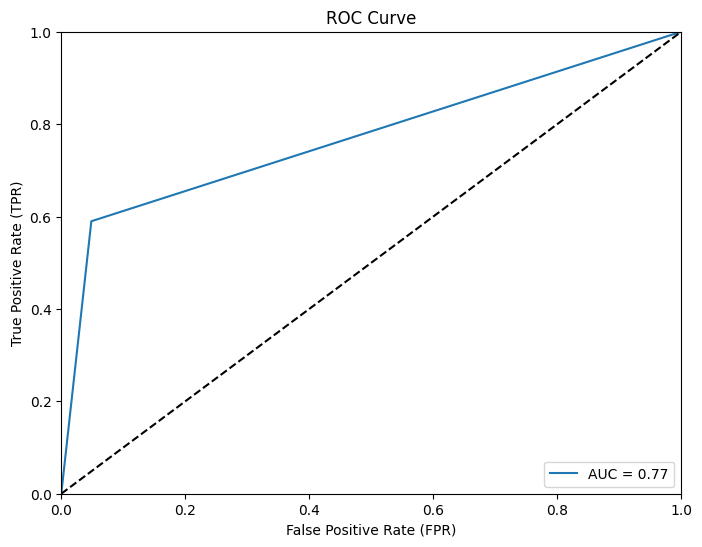

2024-09-01 16:05:53,046 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
2024-09-01 16:05:53,058 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast.py:489: UserWarning: Failed to create lift chart. This indicates an issue with the classifier.
            Check if there is any varance in the predicted probabilities.


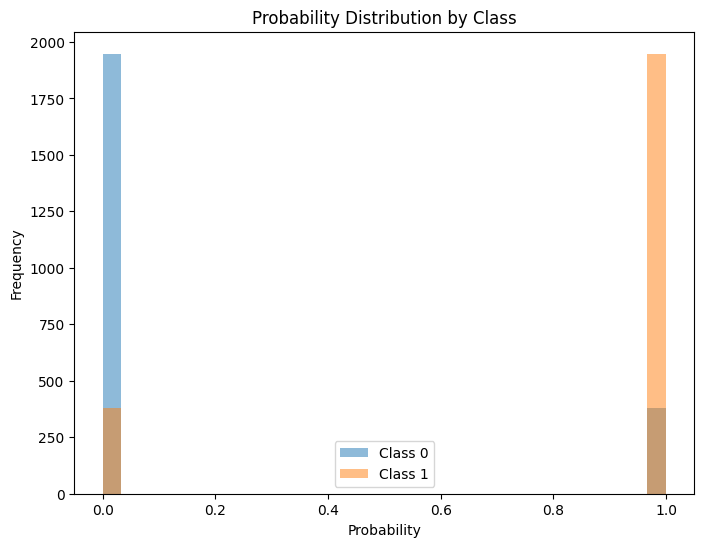

2024-09-01 16:05:53,233 - root - INFO - Start saving out of fold data.


{'matthews': 0.5983411280726222,
 'accuracy': 0.8753224419604472,
 'recall': 0.8753224419604472,
 'f1_score_macro': 0.7946300698551261,
 'f1_score_micro': 0.8753224419604472,
 'f1_score_weighted': 0.8691238509619588,
 'log_loss': 4.493834687379181,
 'balanced_logloss': 7.921125558389048,
 'roc_auc': 0.7706604864167889,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.90      0.95      0.92      1836\n           1       0.76      0.59      0.67       490\n\n    accuracy                           0.88      2326\n   macro avg       0.83      0.77      0.79      2326\nweighted avg       0.87      0.88      0.87      2326\n',
 'confusion_matrix': array([[1747,   89],
        [ 201,  289]])}

In [16]:
automl_baseline.fit_eval(
    df=train,
    df_eval=train_eval,
    target_eval=target_eval,
    target_col=TARGET,
)


In [17]:
y_probs, y_classes = automl_baseline.predict(test)

2024-09-01 16:05:53,313 - root - INFO - Start casting feature types.
2024-09-01 16:05:53,320 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-09-01 16:05:53,320 - root - INFO - Dropped the following columns as constants only: [].
2024-09-01 16:05:53,325 - root - INFO - Start filling infinite values.
2024-09-01 16:05:53,360 - root - INFO - Start date column conversion.
2024-09-01 16:05:53,361 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-09-01 16:05:53,386 - root - INFO - Predicting...


In [18]:
submission[TARGET] = y_probs
submission.to_csv("automl_custom_catboost_bluecast_pipeline.csv", index=False)
submission

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0
...,...,...
110018,275052,0
110019,275053,0
110020,275054,0
110021,275055,0


# Summary

Scores with default data and settings:

* 'matthews': 0.5993440564359245,
* 'accuracy': 0.8774720550300946,
* 'recall': 0.8774720550300946,
* 'log_loss': 0.29695461567511755,
* 'balanced_logloss': 0.5164093971252441,
* 'roc_auc': 0.9052232003912677


# What would have happened afterwards?

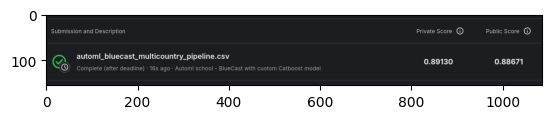

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('automl_bluecast_custom_catboost_kaggle.png')
imgplot = plt.imshow(img)
plt.show()

That would have been rank 895 out of 3633 with a single model and not using all data! We have built this within little time while participants in the competition had a full month.